In [2]:
import pandas as pd

# Load processed data
ecom_data = pd.read_csv('../data/processed/feature_engineered_Fraud_Data.csv')
bank_data = pd.read_csv('../data/raw/creditcard.csv')  # Already PCA-transformed
print("Done")

Done


In [3]:
# E-commerce
X_ecom = ecom_data.drop('class', axis=1)
y_ecom = ecom_data['class']

# Bank
X_bank = bank_data.drop('Class', axis=1)
y_bank = bank_data['Class']
print("Done")

Done


In [4]:
from sklearn.model_selection import train_test_split

print(type(X_ecom))
print(X_ecom.shape)
print(type(X_bank))
print(X_bank.shape)

# E-commerce
X_train_ecom, X_test_ecom, y_train_ecom, y_test_ecom = train_test_split(
    X_ecom, y_ecom, test_size=0.2, stratify=y_ecom, random_state=42)

# Bank
X_train_bank, X_test_bank, y_train_bank, y_test_bank = train_test_split(
    X_bank, y_bank, test_size=0.2, stratify=y_bank, random_state=42)
print("Done")

<class 'pandas.core.frame.DataFrame'>
(151112, 16)
<class 'pandas.core.frame.DataFrame'>
(284807, 30)
Done


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Example numeric + categorical features (you can adjust)
num_features = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day']
cat_features = ['source', 'browser', 'sex', 'country']

# Create transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])
print("Done")

Done


In [6]:
X_train_ecom_transformed = preprocessor.fit_transform(X_train_ecom)
X_test_ecom_transformed = preprocessor.transform(X_test_ecom)
print("Done")

Done


In [7]:
# For e-commerce
from imblearn.over_sampling import SMOTE

X_train_ecom_transformed = preprocessor.fit_transform(X_train_ecom)
X_test_ecom_transformed = preprocessor.transform(X_test_ecom)

smote = SMOTE(random_state=42)
X_train_ecom_res, y_train_ecom_res = smote.fit_resample(X_train_ecom_transformed, y_train_ecom)

# For bank
scaler = StandardScaler()
X_train_bank_scaled = scaler.fit_transform(X_train_bank)
X_test_bank_scaled = scaler.transform(X_test_bank)

X_train_bank_res, y_train_bank_res = smote.fit_resample(X_train_bank_scaled, y_train_bank)
print("Done")

Done


In [8]:

# LogisticRegression

from sklearn.linear_model import LogisticRegression

lr_ecom = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_ecom.fit(X_train_ecom_res, y_train_ecom_res)

lr_bank = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_bank.fit(X_train_bank_res, y_train_bank_res)
print("Done")


Done


In [9]:
#XGBoost

from xgboost import XGBClassifier

# For bank data you can calculate imbalance ratio
ratio = y_train_bank.value_counts()[0] / y_train_bank.value_counts()[1]

xgb_ecom = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss')
xgb_ecom.fit(X_train_ecom_res, y_train_ecom_res)

xgb_bank = XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss')
xgb_bank.fit(X_train_bank_res, y_train_bank_res)
print("Done")

/home/saron/MySpace/AI/kifya/week8/Fraud_Detection/notebooks/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:07:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done


In [11]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, auc

## Logistic Regression - e-commerce
y_pred_lr = lr_ecom.predict(X_test_ecom_transformed)
y_prob_lr = lr_ecom.predict_proba(X_test_ecom_transformed)[:, 1]

print("Logistic Regression (E-commerce):")
print(classification_report(y_test_ecom, y_pred_lr))
print("F1 Score:", f1_score(y_test_ecom, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test_ecom, y_prob_lr))

precision, recall, _ = precision_recall_curve(y_test_ecom, y_prob_lr)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)
print("Done")


Logistic Regression (E-commerce):
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     27393
           1       0.17      0.69      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223

F1 Score: 0.2702777777777778
ROC AUC: 0.742640952222841
AUC-PR: 0.39218687902477023
Done


In [12]:
## Logistic Regression - bank
y_pred_lr_bank = lr_bank.predict(X_test_bank_scaled)
y_prob_lr_bank = lr_bank.predict_proba(X_test_bank_scaled)[:, 1]

print("Logistic Regression (Bank):")
print(classification_report(y_test_bank, y_pred_lr_bank))
print("F1 Score:", f1_score(y_test_bank, y_pred_lr_bank))
print("ROC AUC:", roc_auc_score(y_test_bank, y_prob_lr_bank))

precision, recall, _ = precision_recall_curve(y_test_bank, y_prob_lr_bank)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

Logistic Regression (Bank):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

F1 Score: 0.10876132930513595
ROC AUC: 0.9708434302252134
AUC-PR: 0.769946476318381


In [13]:

#XGBoost – E-commerce
y_pred_xgb_ecom = xgb_ecom.predict(X_test_ecom_transformed)
y_prob_xgb_ecom = xgb_ecom.predict_proba(X_test_ecom_transformed)[:, 1]

print("XGBoost (E-commerce):")
print(classification_report(y_test_ecom, y_pred_xgb_ecom))
print("F1 Score:", f1_score(y_test_ecom, y_pred_xgb_ecom))
print("ROC AUC:", roc_auc_score(y_test_ecom, y_prob_xgb_ecom))

precision, recall, _ = precision_recall_curve(y_test_ecom, y_prob_xgb_ecom)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

XGBoost (E-commerce):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.95      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223

F1 Score: 0.6789115646258503
ROC AUC: 0.7622010227007261
AUC-PR: 0.6007956333562009


In [14]:
#XGBoost – Bank:
y_pred_xgb_bank = xgb_bank.predict(X_test_bank_scaled)
y_prob_xgb_bank = xgb_bank.predict_proba(X_test_bank_scaled)[:, 1]

print("XGBoost (Bank):")
print(classification_report(y_test_bank, y_pred_xgb_bank))
print("F1 Score:", f1_score(y_test_bank, y_pred_xgb_bank))
print("ROC AUC:", roc_auc_score(y_test_bank, y_prob_xgb_bank))

precision, recall, _ = precision_recall_curve(y_test_bank, y_prob_xgb_bank)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

XGBoost (Bank):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.86      0.63        98

    accuracy                           1.00     56962
   macro avg       0.75      0.93      0.81     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.6292134831460674
ROC AUC: 0.9789350602368128
AUC-PR: 0.8474159647940935


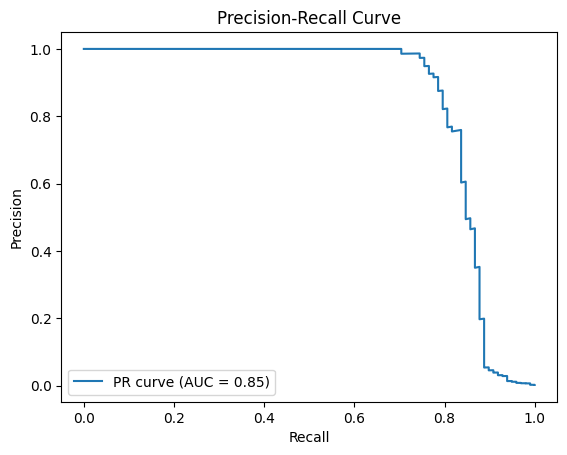

In [15]:
import matplotlib.pyplot as plt

# PR Curve
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('../reports/figures/pr_curve_lr_ecom.png')
plt.show()
